In [315]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os
import random

from skimage.color import rgb2hsv, rgb2gray
from utils import load_input_image
from segmentation import Segementation
from sklearn.decomposition import KernelPCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from scipy.stats import kurtosis, skew


In [316]:
def color_features(img):
    median = np.median(img, axis=(0, 1))
    std = np.std(img, axis=(0, 1))
    mean = np.mean(img, axis=(0, 1))
    kurtosis_c = kurtosis(img, axis=(0, 1))
    skew_c = skew(img, axis=(0, 1))
    img_hsv = rgb2hsv(img)
    median_hsv = np.median(img_hsv, axis=(0, 1))
    std_hsv = np.std(img_hsv, axis=(0, 1))
    mean_hsv = np.mean(img_hsv, axis=(0, 1))
    kurtosis_hsv = kurtosis(img_hsv, axis=(0, 1))
    skew_hsv = skew(img_hsv, axis=(0, 1))

    return np.hstack(
        [
            median,
            std,
            mean,
            kurtosis_c,
            skew_c,
            median_hsv,
            std_hsv,
            mean_hsv,
            kurtosis_hsv,
            skew_hsv,
        ]
    )

In [317]:
def fourier_features(img):
    transform = np.fft.fft2(rgb2gray(img))
    ft = np.log(np.abs(np.fft.fftshift(transform)))[1:, 1:]  # [51:-50, 51:-50]

    ft_median = np.median(ft)
    ft_mean = np.mean(ft)
    ft_std = np.std(ft)
    ft_kurtosis = kurtosis(ft, axis=(0, 1))
    ft_skew = skew(ft, axis=(0, 1))

    binary_ft = ft > 4.5
    non_zero = np.count_nonzero(binary_ft)
    v = np.stack(np.where(binary_ft), axis=1)
    cov = np.cov(v.T)
    eigval, eigvec = np.linalg.eig(cov)

    idx = np.argsort(eigval)
    eigval, eigvec = eigval[idx], eigvec[idx]

    angle = np.arctan2(eigvec[0][1], eigvec[0][0]) % (np.pi / 2)

    k, l = np.indices((127, 127)) - 63
    m_00 = np.sum(ft)
    m_20 = np.sum(k**2 * ft)
    m_02 = np.sum(l**2 * ft)
    M1 = m_02 + m_20

    return np.hstack(
        [
            ft_median,
            ft_mean,
            ft_std,
            ft_kurtosis,
            ft_skew,
            non_zero,
            eigval,
            angle,
            M1 / m_00,
        ]
    )

In [318]:
def get_features(img):
    # COLOR
    color = color_features(img)

    # FOURIER
    fourier = fourier_features(img)

    # EDGES
    canny_img = cv2.Canny(img, 50, 200)
    num_edges = np.count_nonzero(canny_img)

    return np.hstack([color, fourier, num_edges])

In [319]:
def correlate(img1, img2):
    return (
        np.sum((img1 - np.mean(img1)) * (img2 - np.mean(img2))) / (np.std(img1) * np.std(img2) * np.size(img1))
    )

In [320]:
def get_correlation(pieces):
    crop_imgs = []
    distances = []

    for img in pieces:
        transform = np.fft.fft2(rgb2gray(img))
        fshift = np.fft.fftshift(transform)
        crop_img = np.log(np.abs(fshift[51:-50, 51:-50]))
        crop_imgs.append(crop_img)

    for img in crop_imgs:
        arr = np.array(
            [
                max(correlate(b,img), correlate(np.rot90(b),img))
                for b in crop_imgs
            ]
        )
        distances.append(arr)

    distances = np.array(distances)

    return distances

In [321]:
def get_distances_non_binary(pieces):
    crop_imgs = []
    distances = []

    for img in pieces:
        transform = np.fft.fft2(rgb2gray(img))
        fshift = np.fft.fftshift(transform)
        crop_img = np.log(np.abs(fshift[51:-50, 51:-50]))
        crop_imgs.append(crop_img)

    for img in crop_imgs:
        arr = np.array(
            [
                min(np.sum((b - img) ** 2), np.sum((np.rot90(b) - img) ** 2))
                for b in crop_imgs
            ]
        )
        distances.append(arr)


    distances = np.array(distances)
    normalized_distances = normalize(distances, axis=0)

    return normalized_distances

In [322]:
imgs = {i: load_input_image(i,folder="train2") for i in range(12)}

In [323]:
sorted_pieces = [
    [[0,2,8,9,10,12,13,14,19], [1,5,6,11,16,21,22,25,26], [3,4,7,15,17,18,20,24]    ,[23]], 
    [[2,4,7,8,10,11,12,13,14], [0,1,5,6,9,15,16,17,19]  , []                        ,[3,18,20]],
    [[2,5,6,17,19,20,22,23,24],[1,4,9,13,15,18,21,25,26], [3,7,8,10,11,12,14,16,27] ,[0]],
    [[0,1,2,5,11,12,13,16,17], [3,4,6,7,8,9,15,18,20]   , []                        ,[10,14,19]],
    [[1,3,5,7,8,9,11,15,18]  , [2,4,6,10,12,13,14,17,19], []                        ,[0,16]],
    [[3,4,6,7,9,10,15,19,24],  [0,8,12,14,16,17,18,20,26],[1,2,5,11,13,21,22,23,27] ,[25]],
    [[0,2,5,8,10,18,25,26,27], [1,3,4,12,14,15,17,21,23], [6,7,9,11,16,19,22,24,28] ,[13, 20]],
    [[0,1,7,9,12,14,19,23,27], [2,4,5,13,18,22,24,25,26], [3,8,10,11,15,16,17,20,21],[6]],
    [[0,1,2,5,6,8,11,12,14,15,16,18,20,21,23,26],[3,4,7,9,10,13,19,22,25],[]        ,[17,24]],
    [[0,2,4,5,6,13,17,23,25],  [1,9,10,12,14,15,16,19,22],[7,8,18,20,21,24,26,27,28],[3,11]],
    [[0,1,8,12,14,17,18,20,22],[2,3,4,9,10,15,16,21,23] , [5,6,7,11,13,19,25,26,27] ,[24]],
    [[1,2,5,6,9,11,14,15,18],  [3,4,7,8,10,12,13,16,17],  []                        ,[0]]
]

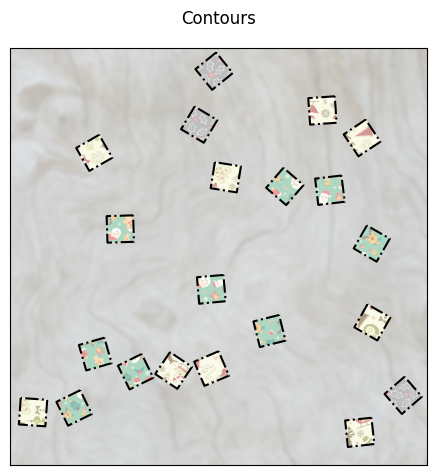

In [538]:
index_img = 1
img = imgs[index_img]
seg = Segementation(img)
seg.find_pieces()
seg.plot_contours()

In [539]:
sorted_pieces[index_img]

[[2, 4, 7, 8, 10, 11, 12, 13, 14],
 [0, 1, 5, 6, 9, 15, 16, 17, 19],
 [],
 [3, 18, 20]]

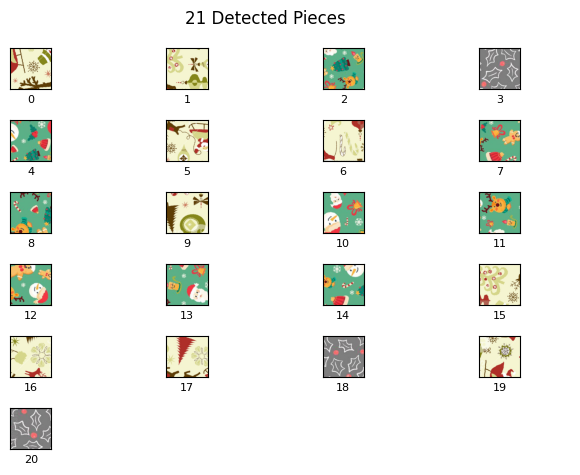

In [540]:
seg.plot_pieces()

In [541]:
features = np.array([get_features(seg.pieces[i]) for i in range(len(seg.pieces))])
distances = get_distances_non_binary(seg.pieces)
correlation = get_correlation(seg.pieces)
features = np.hstack([features, distances, correlation])
features = (features - np.mean(features, axis=0)) / np.maximum(1e-10, np.std(features, axis=0))
features.shape

(21, 83)

In [542]:
pca = KernelPCA(n_components=3,kernel="rbf")
features_PCA = pca.fit_transform(features)

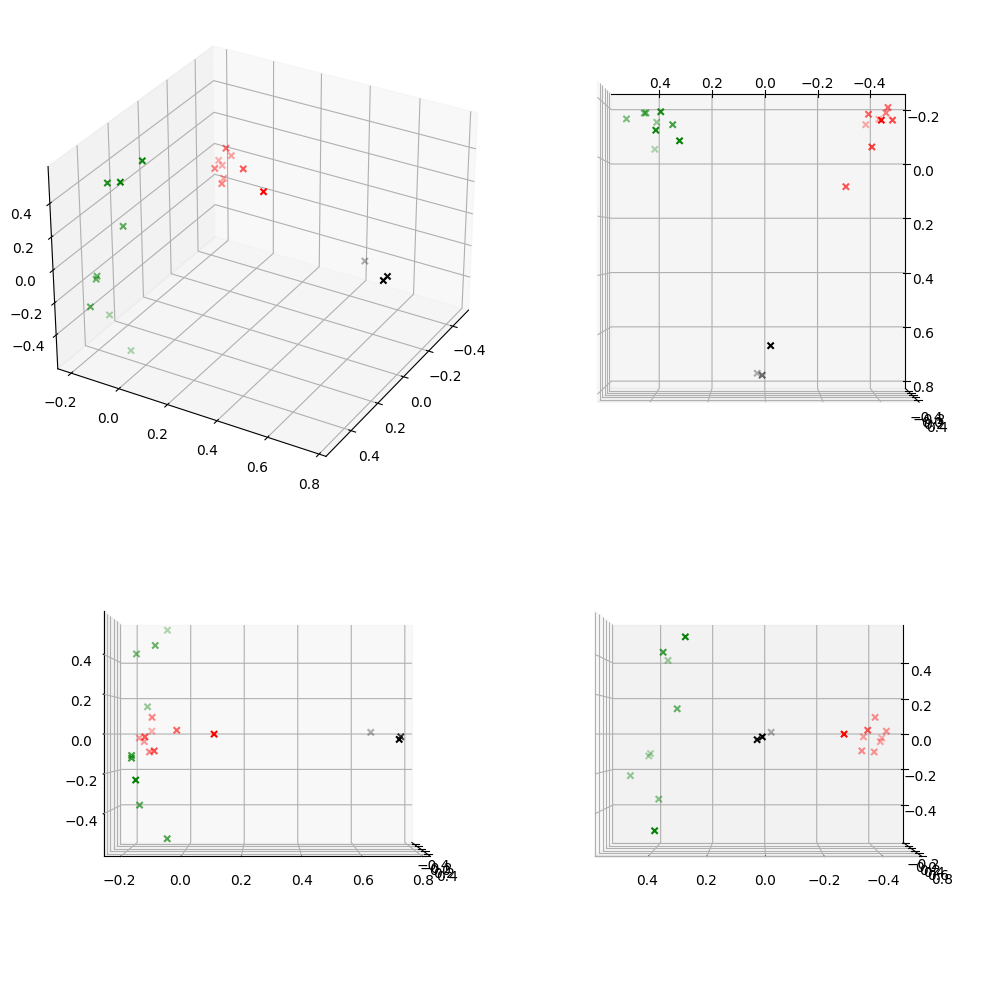

In [543]:
indexes = sorted_pieces[index_img]

colors = ["r", "g", "b", "k", "c", "m"]
orientation = [(30, 30), (90, 90), (0, 0), (0, 90)]

fig = plt.figure(figsize=(10, 10))
for i, o in enumerate(orientation):
    ax = fig.add_subplot(2, 2, i + 1, projection="3d")
    for j, index in enumerate(indexes):
        ax.scatter(*features_PCA[index].T, c=colors[j], marker="x")
        ax.view_init(elev=o[0], azim=o[1])

plt.tight_layout()
# plt.savefig(f'classification_{index_img}')
plt.show()

In [544]:
gm_2 = GaussianMixture(n_components=2, n_init=10)
gm_3 = GaussianMixture(n_components=3, n_init=10)
gm_4 = GaussianMixture(n_components=4, n_init=10)

labels_2 = gm_2.fit_predict(features_PCA)
labels_3 = gm_3.fit_predict(features_PCA)
labels_4 = gm_4.fit_predict(features_PCA)

probs_2 = gm_2.predict_proba(features_PCA)
probs_3 = gm_3.predict_proba(features_PCA)
probs_4 = gm_4.predict_proba(features_PCA)

In [554]:
def classify(features_PCA):
    n_pieces = [16, 12, 9]
    
    gm = [None]*2
    labels = [None]*2
    aic_values = []

    for i in range(2):
        gm[i] = GaussianMixture(n_components=i+2, n_init=10)
        labels[i] = gm[i].fit_predict(features_PCA)
        

        features_filtered = features_PCA.copy()
        
        for label in np.unique(labels[i]):
            current_label_mask = labels[i] == label
            cluster_samples = features_PCA[current_label_mask]
            num_pieces = len(cluster_samples)

            for n in n_pieces:
                valid_samples_mask = np.ones(len(features_PCA), dtype=bool)

                if (n == 9 and 9 < num_pieces <= 12) or (n == 12 and 12 < num_pieces <= 16) or (n == 16 and num_pieces > 16):
                    centroid = gm[i].means_[label]
                    distances = np.sqrt(np.sum((cluster_samples - centroid) ** 2, axis=1))
                    distances_sorted = np.sort(distances)
                    threshold = distances_sorted[n-1]
                    outlier_mask = distances > threshold
                    outlier_samples_mask = np.zeros(len(features_PCA[current_label_mask]), dtype=bool)
                    outlier_samples_mask[current_label_mask[current_label_mask]] = outlier_mask

                    valid_samples_mask[current_label_mask] &= ~outlier_samples_mask


                labels_filtered = labels[i].copy()
                labels_filtered[~valid_samples_mask] = -1 
                features_filtered = features_PCA[valid_samples_mask]

                num_pieces_filtered = []
                for label_check in np.unique(labels[i]):
                    num_pieces_filtered.append(np.count_nonzero(labels_filtered == label_check))
                
                if all(num in n_pieces for num in num_pieces_filtered):
                    if len(features_filtered) >= i+2:  
                        gm[i].fit(features_filtered)
                        aic_value = gm[i].aic(features_filtered)
                        aic_values.append((aic_value, labels_filtered))
                        print(f'Model: {i+2}, Pieces: {n}, Label: {label}, AIC: {aic_value}')
                    else:
                        print(f'Model: {i+2}, Pieces: {n}, Label: {label}, AIC: Not enough samples')

    aic_values_only = np.array([x[0] for x in aic_values])
    aic_min_index = np.argmin(aic_values_only)
    filtered_labels = aic_values[aic_min_index][1]

    return filtered_labels


In [555]:
labels = classify(features_PCA)
labels

Model: 2, Pieces: 16, Label: 0, AIC: -75.44438617425763
Model: 2, Pieces: 12, Label: 0, AIC: -75.44438617425763
Model: 2, Pieces: 9, Label: 0, AIC: -80.95528828267076
Model: 2, Pieces: 16, Label: 1, AIC: -75.44438617425763
Model: 2, Pieces: 12, Label: 1, AIC: -75.44438617425763
Model: 2, Pieces: 9, Label: 1, AIC: -75.44438617425763


array([ 1,  1,  0, -1,  0,  1,  1,  0,  0,  1,  0,  0,  0,  0,  0,  1,  1,
        1, -1,  1, -1], dtype=int64)

In [556]:
sorted_pieces[index_img]

[[2, 4, 7, 8, 10, 11, 12, 13, 14],
 [0, 1, 5, 6, 9, 15, 16, 17, 19],
 [],
 [3, 18, 20]]

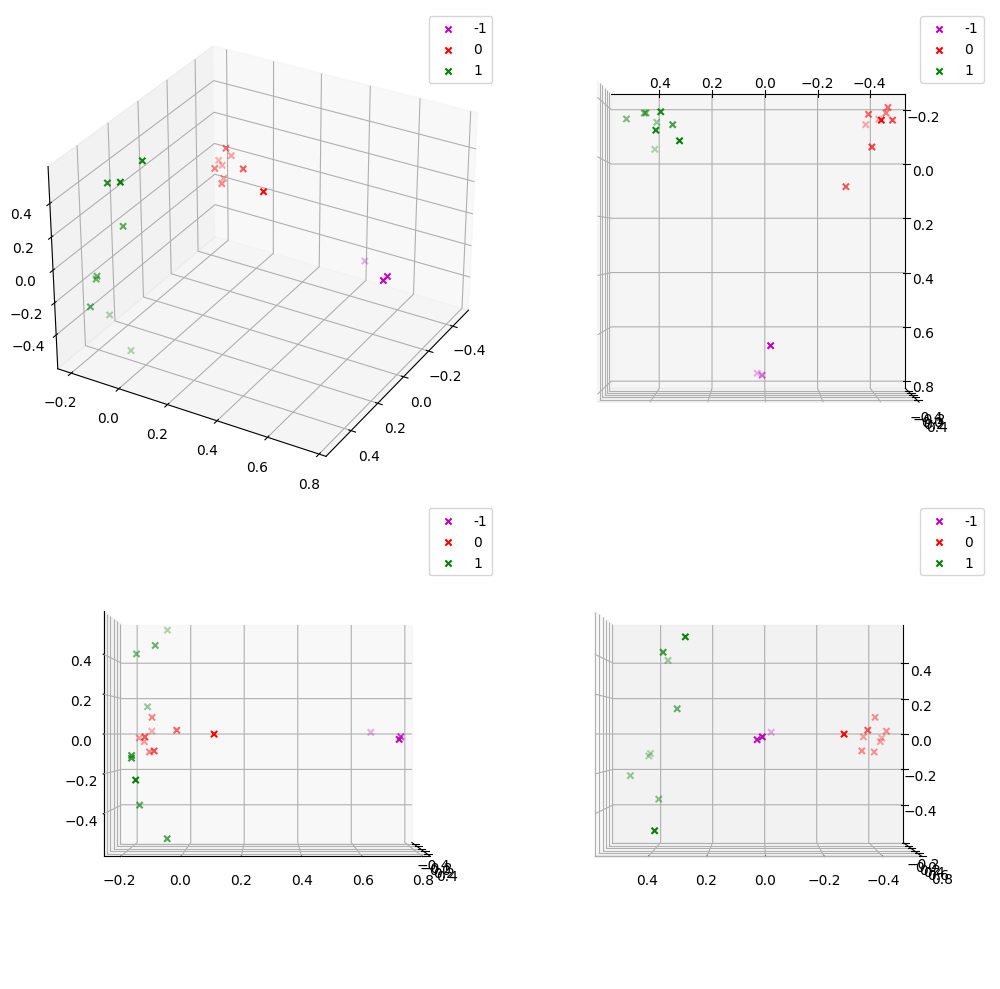

In [557]:
fig = plt.figure(figsize=(10,10))

for i, o in enumerate(orientation):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    for label in np.unique(labels):
        ax.scatter(*features_PCA[labels==label].T, c=colors[label], marker='x', label=label)
        ax.view_init(elev=o[0], azim=o[1])
    ax.legend()

plt.tight_layout()
plt.show()

In [549]:
bic_2 = gm_2.bic(features_PCA)
bic_3 = gm_3.bic(features_PCA)
bic_4 = gm_4.bic(features_PCA)

aic_2 = gm_2.aic(features_PCA)
aic_3 = gm_3.aic(features_PCA)
aic_4 = gm_4.aic(features_PCA)

print("BIC gm_2: ", bic_2)
print("BIC gm_3: ", bic_3)
print("BIC gm_4: ", bic_4)

print("AIC gm_2: ", aic_2)
print("AIC gm_3: ", aic_3)
print("AIC gm_4: ", aic_4)


BIC gm_2:  -55.598459857512594
BIC gm_3:  -77.82604034756923
BIC gm_4:  -65.93388977569288
AIC gm_2:  -75.44438617425763
AIC gm_3:  -108.1171910415485
AIC gm_4:  -106.67026484690638


In [550]:
def classify_prob(features_PCA):
    n_pieces = (9, 12, 16)
    
    gm = [None]*2
    labels = [None]*2
    probs = [None]*2
    aic_values = [[] for _ in range(2)]  # a list of lists for storing the AIC values

    for i in range(2):
        gm[i] = GaussianMixture(n_components=i+2, n_init=10)
        labels[i] = gm[i].fit_predict(features_PCA)
        probs[i] = gm[i].predict_proba(features_PCA)

        for n in n_pieces:
            valid_samples_mask = np.ones(len(features_PCA), dtype=bool)

            for label in np.unique(labels[i]):
                cluster_probs = probs[i][labels[i] == label]

                if len(cluster_probs) > n:
                    threshold = 1
                    max_probs = np.max(cluster_probs, axis=1)
                    outliers = np.where(max_probs < threshold)
                    
                    valid_samples_mask[outliers] = False  
            
            labels[i] = labels[i][valid_samples_mask]
            probs[i] = probs[i][valid_samples_mask]
            features_filtered = features_PCA[valid_samples_mask]

            gm[i].fit(features_filtered)
            aic_values[i].append(gm[i].aic(features_filtered))  # append AIC to the inner list
                
            print(f'Model: {i+1}, Pieces: {n}, AIC: {gm[i].aic(features_filtered)}')  
            
                
    min_aic_index = aic_values.index(min(aic_values, key=min))

    return labels[min_aic_index]


In [551]:
def classify_mistake(features_PCA):
    n_pieces = (16, 12, 9)
    
    gm = [None]*2
    labels = [None]*2
    aic_values = [[] for _ in range(2)]

    for i in range(2):
        gm[i] = GaussianMixture(n_components=i+2, n_init=10)
        labels[i] = gm[i].fit_predict(features_PCA)

        for label in np.unique(labels[i]):
            current_label_mask = labels[i] == label
            cluster_samples = features_PCA[current_label_mask]
            num_pieces = len(cluster_samples)

            for n in n_pieces:
                valid_samples_mask = np.ones(len(features_PCA), dtype=bool)

                if (n == 9 and 9 < num_pieces < 12):
                #or (n == 12 and 12 < num_pieces < 16) or (n == 16 and num_pieces > 16):
                    centroid = gm[i].means_[label]
                    distances = np.sqrt(np.sum((cluster_samples - centroid) ** 2, axis=1))
                    distances_sorted = np.sort(distances)
                    threshold = distances_sorted[n-1]
                    outlier_mask = distances > threshold
                    current_valid_samples_mask = np.copy(current_label_mask)
                    current_valid_samples_mask[current_label_mask] = ~outlier_mask

                    valid_samples_mask &= current_valid_samples_mask
                    print(valid_samples_mask)
                    
                    labels_filtered = labels[i][valid_samples_mask]
                    print(labels_filtered)

                features_filtered = features_PCA[valid_samples_mask]

                labels_filtered = labels[i][valid_samples_mask]
                
                #print(labels_filtered)
                if len(features_filtered) >= i+2:  # Check if enough samples for n_components
                    gm[i].fit(features_filtered)
                    aic_value = gm[i].aic(features_filtered)
                    aic_values[i].append(aic_value)
                    print(f'Model: {i+2}, Pieces: {n}, Label: {label}, AIC: {aic_value}')
                else:
                    aic_values[i].append(np.inf)
                    print(f'Model: {i+2}, Pieces: {n}, Label: {label}, AIC: Not enough samples')

    min_aic_index = min(range(len(aic_values)), key=lambda index: min(aic_values[index]))

    filtered_labels = labels[min_aic_index]

    return filtered_labels


In [552]:
bic_values = {'gm_2': bic_2, 'gm_3': bic_3, 'gm_4': bic_4}
aic_values = {'gm_2': aic_2, 'gm_3': aic_3, 'gm_4': aic_4}

best_bic_model = min(bic_values, key=bic_values.get)
best_aic_model = min(aic_values, key=aic_values.get)

print("Best BIC model: ", best_bic_model)
print("Best AIC model: ", best_aic_model)


Best BIC model:  gm_3
Best AIC model:  gm_3


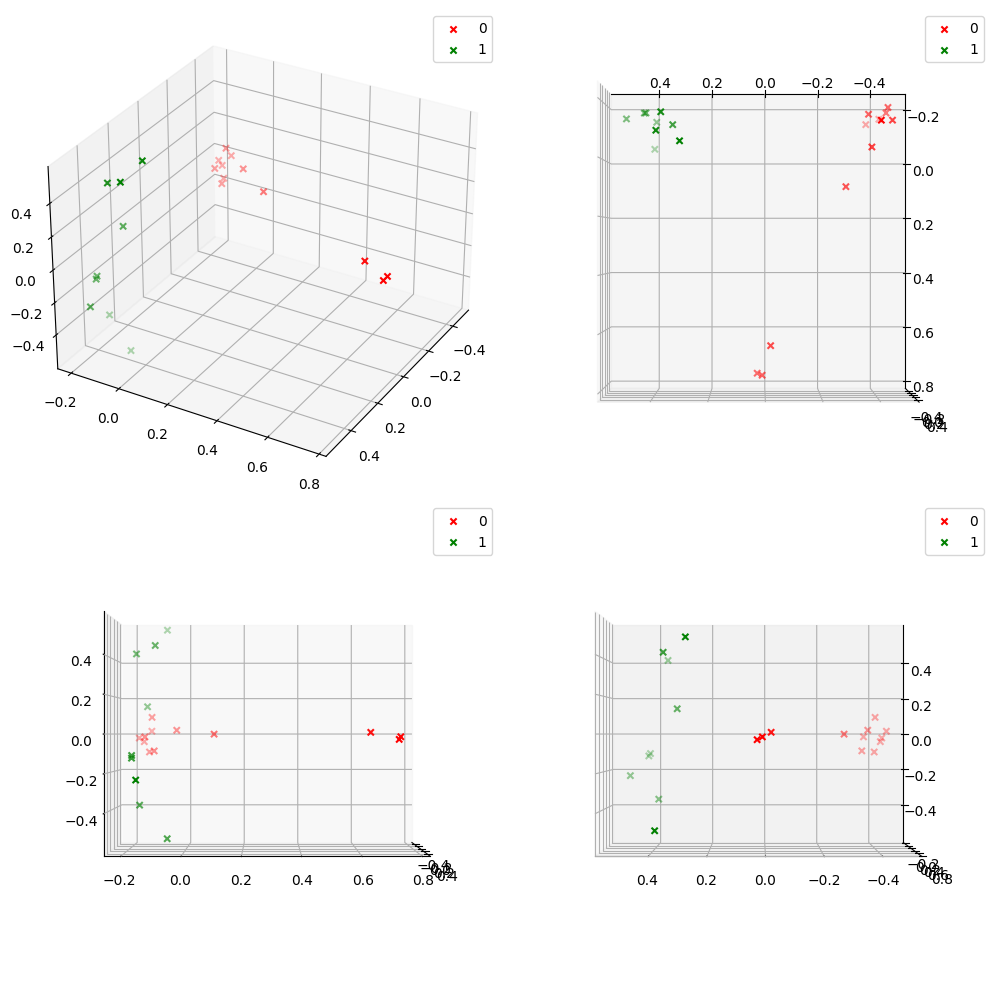

In [553]:
fig = plt.figure(figsize=(10,10))

for i, o in enumerate(orientation):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    for label in np.unique(labels):
        ax.scatter(*features_PCA[labels==label].T, c=colors[label], marker='x', label=label)
        ax.view_init(elev=o[0], azim=o[1])
    ax.legend()

plt.tight_layout()
plt.show()